<a href="https://colab.research.google.com/github/WasnikKarolina/CNN_flowers/blob/main/CNN_flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview: Image Classification

This project builds a deep learning image classification model using TensorFlow and Keras. It trains a Convolutional Neural Network (CNN) on a dataset of flower images to classify them into categories. The model includes data preprocessing, augmentation, and optimization techniques. After training, it evaluates the model's performance and predicts the class of new images with confidence scores.

# Setup: Libraries

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Downloading and exploring the dataset

In [27]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images: ", image_count)

Number of images:  3670


Roses example:

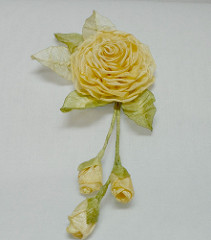

In [28]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
PIL.Image.open(str(roses[1]))

# Loading the data from the disk into a dataset object (Keras utility)

In [29]:
batch_size = 32
img_height = 180
img_width = 180

Validation split:

In [30]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Printing class names:

In [31]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualising the data

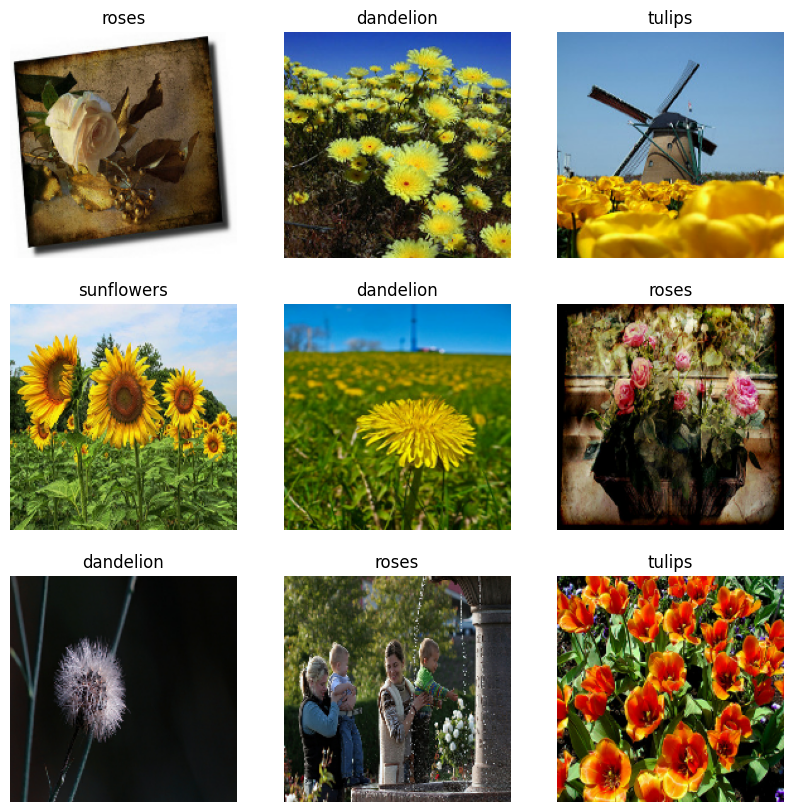

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Buffered prefetching

In [33]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardizing the data

In [50]:
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print("Range:", np.min(first_image), "-", np.max(first_image))

Range: 0.0 - 1.0


#Creating the model

In [35]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Compiling the model

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Viewing all the layers of the network:

In [37]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,285 (15.22 MB)

 Trainable params: 3,989,285 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

In [59]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.8124 - loss: 0.4988 - val_accuracy: 0.7452 - val_loss: 0.6898
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8399 - loss: 0.4419 - val_accuracy: 0.7330 - val_loss: 0.7304
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.8188 - loss: 0.4551 - val_accuracy: 0.7343 - val_loss: 0.7390
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8305 - loss: 0.4432 - val_accuracy: 0.7452 - val_loss: 0.7039
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8108 - loss: 0.4771 - val_accuracy: 0.7425 - val_loss: 0.7239
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8390 - loss: 0.4261 - val_accuracy: 0.7357 - val_loss: 0.7290
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 146s 1s/step - accuracy: 0.8631 - loss: 0.3830 - val_accuracy: 0.7493 - val_loss: 0.7357
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.8644 - loss: 0.3712 - val_accuracy: 0.7398 - v

# Visualising training results

Creating plots of the loss and accuracy on the training and validation sets:

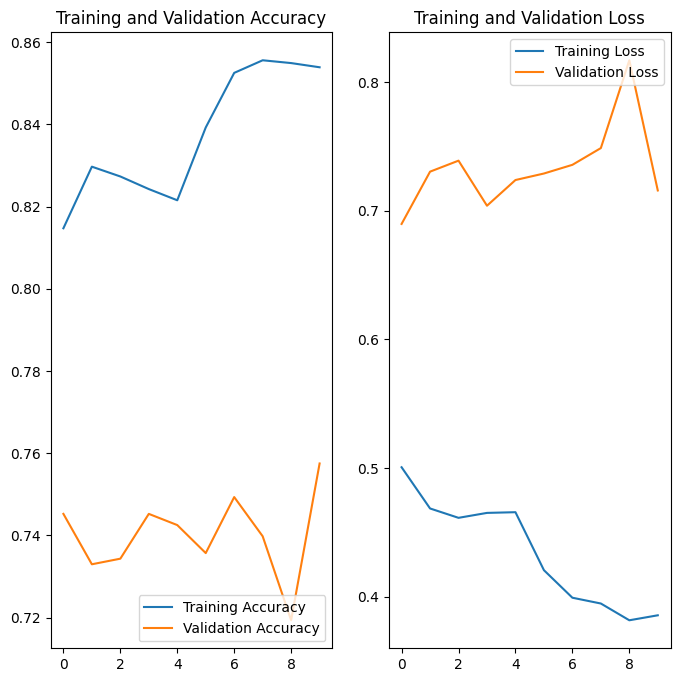

In [60]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Adressing overfitting: Data Augmentation

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualising a few examples:

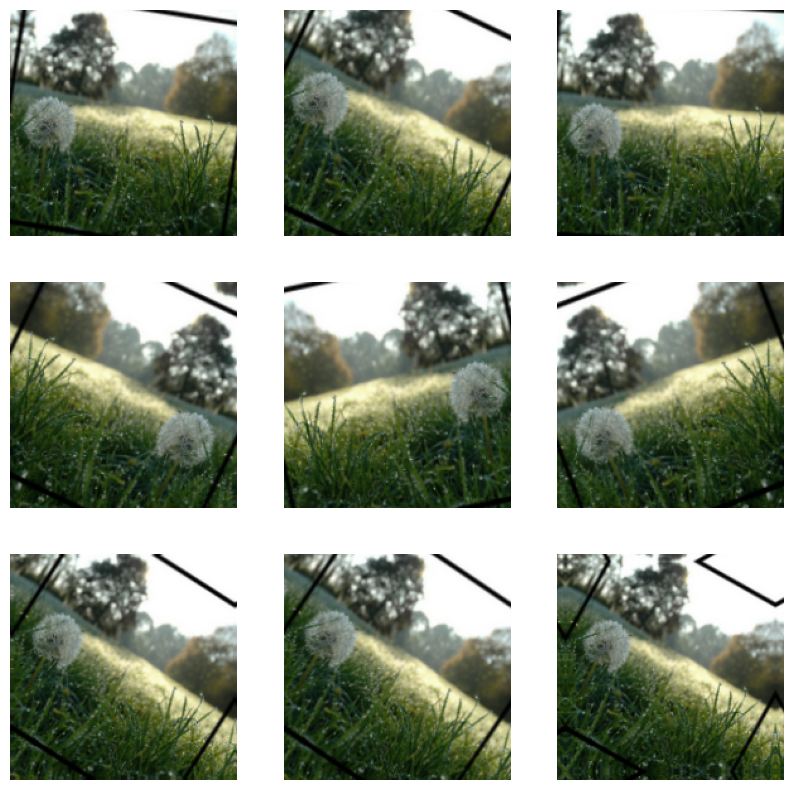

In [52]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Adressing overfitting: Dropout

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# Compiling and training the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [61]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8675 - loss: 0.3606 - val_accuracy: 0.7234 - val_loss: 0.8562
Epoch 2/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8801 - loss: 0.3245 - val_accuracy: 0.7425 - val_loss: 0.7660
Epoch 3/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.8786 - loss: 0.3206 - val_accuracy: 0.7520 - val_loss: 0.7966
Epoch 4/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8965 - loss: 0.3095 - val_accuracy: 0.7738 - val_loss: 0.7606
Epoch 5/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - accuracy: 0.8821 - loss: 0.2976 - val_accuracy: 0.7425 - val_loss: 0.8303
Epoch 6/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9060 - loss: 0.2700 - val_accuracy: 0.7480 - val_loss: 0.8976
Epoch 7/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8905 - loss: 0.2994 - val_accuracy: 0.7316 - val_loss: 0.8922
Epoch 8/15
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8876 - loss: 0.2988 - val_accuracy: 0.7439 - v

## Visualising training results

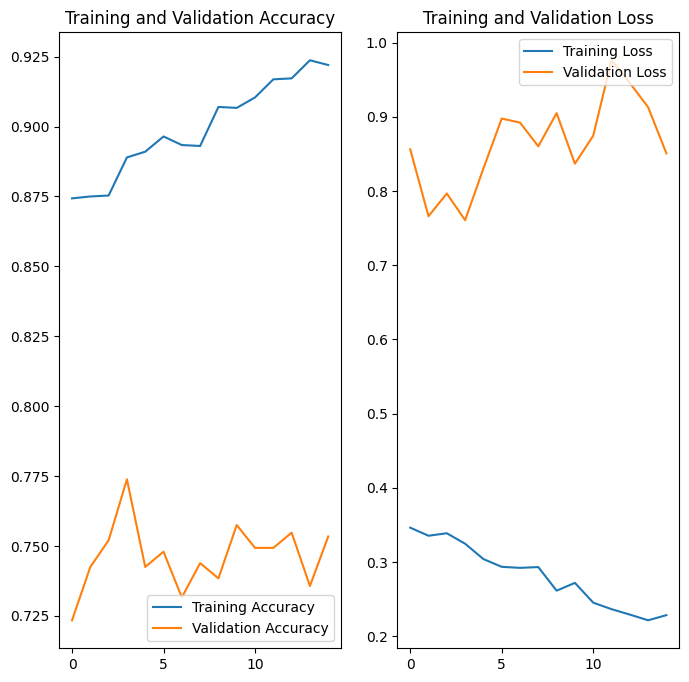

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predicting on new data

In [53]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
This image most likely belongs to sunflowers with a 85.83 percent confidence.
